# PyTorch Custom Dataset

In [9]:
import torch
from torch import nn

torch.__version__

'2.7.1'

## 1. Get Some data

Our dataset is a subset of the Food101 dataset.Food101 starts 101 different classes of food and our dataset starts with 3 classes of the food and only 10% of the images (~ 75 percentage train, 25 percentage test).

When starting out ML project, its important to try things on a small scale and then increase the scale when necessary.
The whole point is to speed up how fast can we experiment and iterate.

In [10]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Download parent dataset (if not already downloaded)
if image_path.is_dir():
    print(f"{image_path} directory exists, skipping download...")
else:
    print(f"Does not exit, creating {image_path}...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download the pizza, steak, sushi images
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi dataset...")
    f.write(request.content)

# Unzip pizza, steak, sushi dataset
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print(f"Unzipping pizza, steak, sushi dataset...")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi directory exists, skipping download...
Unzipping pizza, steak, sushi dataset...


## 2. Becoming one with the data ( data preparation and data exploration )

In [11]:
import os
def walk_through_dir(dir_path):
    """
    Walk through dir_path returning its contents.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [12]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [13]:
# Setup training and test path

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize and images
1. Get all of the image paths
2. Pick a random images using Python's `random.choice`
3. Get the image class name `pathlib.Path().parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then shown the image and print metadata

Random image path: data/pizza_steak_sushi/train/steak/2825100.jpg
Image class name: steak
Image height: 512
Image width: 512


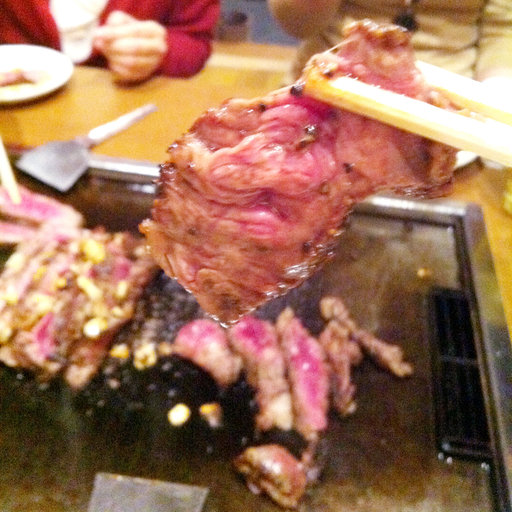

In [14]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class name (the image class is the name of parent directory where the image is stored)
image_class_name = random_image_path.parent.stem

# 4. Open an image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class name: {image_class_name}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

# 6. Display an image
img


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

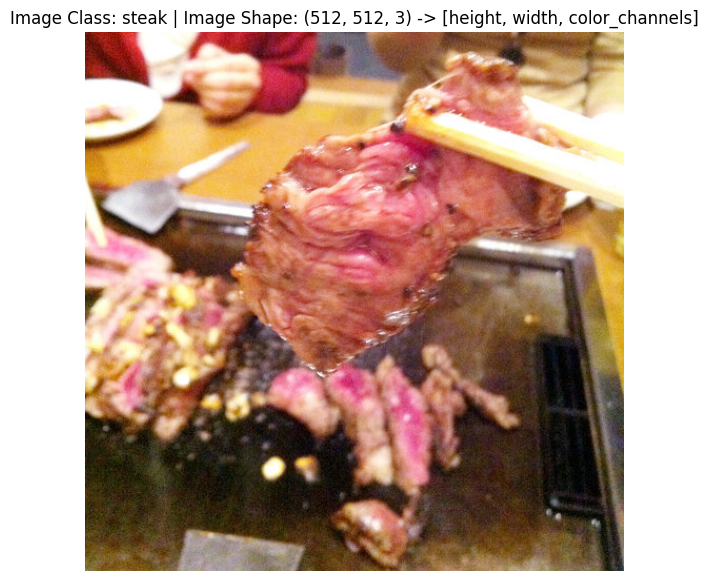

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array 
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class_name} | Image Shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)


## 3. Transforming data

Before we can use our image data with PyTorch.
1. Turn your data into tensors(in our case, numerical representation of the our image).
2. Turn it into a `torch.utils.data.DataLoader` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets    
from torchvision.transforms.v2 import Compose,Resize,RandomHorizontalFlip,ToImage, ToDtype

### 3.1 Transforming data with `torchvision.transforms`

Transform help you get your image ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [17]:
# Write a transform for image
data_transform =Compose([
    # Resize our image to 64X64
    Resize((64, 64)),
    # Flip the image randomly horizontally
    RandomHorizontalFlip(p=0.5),
    # Convert the image to a tensor
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

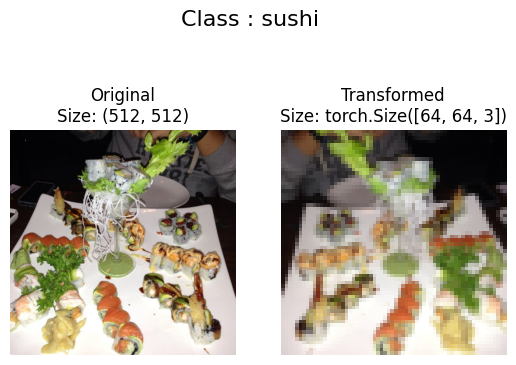

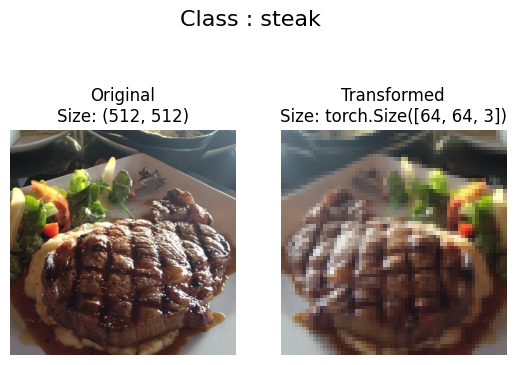

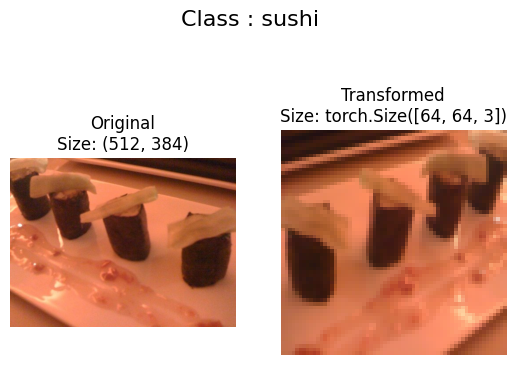

In [18]:
def plot_transformed_images(image_paths, transform, n=3, random_seed = None):
    """ 
    Select random images from a path of images and load/transform them then plots the orignal vs the transformed version.
    """
    # 1. Set random seed
    if random_seed:
        random.seed(random_seed)
    
    random_image_paths = random.sample(list(image_paths), k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # 2. Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            # 3. Show the plot
            plt.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)


plot_transformed_images(
    image_paths = image_path_list,
    transform = data_transform,
    n = 3,
    random_seed = None
)


## 4.(Optional 1) Loading image data using image `ImageFolder` 

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

In [19]:
# use ImageFolder to create a dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                transform = data_transform, # a transform for the data
                                target_transform = None # a transform for the labels/target
                                )
test_data = datasets.ImageFolder(root=test_dir,
                                transform = data_transform,
                                target_transform = None)
train_data, test_data                              

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToImage()
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToImage()
                  ToDtype(scale=True)
            ))

In [20]:
# Get class name
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [21]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
# Check the lenght of data set
len(train_data), len(test_data)

(225, 75)

In [23]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n {img}")
print(f"Image Shape:\n {img.shape}")
print(f"Image type:\n {img.dtype}")
print(f"Label:\n {label}")
print(f"Label type:\n {type(label)}")

Image Tensor:
 Image([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
        [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
        [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
        ...,
        [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
        [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
        [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

       [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
        [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
        [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
        ...,
        [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
        [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
        [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

       [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
        [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
        [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.01

Original shape: torch.Size([3, 64, 64]) -> [C, H, W]
Permuted shape: torch.Size([64, 64, 3]) -> [H, W, C]


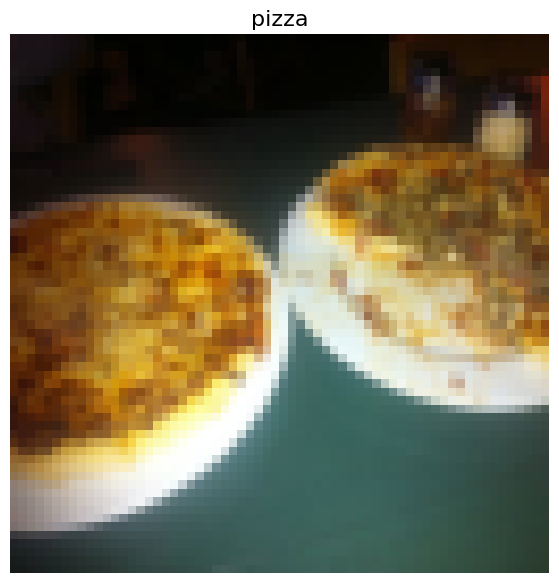

In [24]:
# Rearrange the order dimensions
img_permuted = img.permute(1, 2, 0)

# Print out different shape
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Permuted shape: {img_permuted.shape} -> [H, W, C]")

# Plot the imagep
plt.figure(figsize=(10, 7))
plt.imshow(img_permuted);
plt.axis(False);
plt.title(class_names[label],fontsize=16);


### 4.1 Turn loades images to `DataLoader`

A `DataLoader` is going to help use turn our `Dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [25]:
import os
os.cpu_count()

8

In [26]:
# Turn train and test dataset into DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data, 
                                batch_size=BATCH_SIZE, 
                                num_workers=os.cpu_count(),
                                shuffle=True)

test_dataloader = DataLoader(dataset = test_data, 
                                batch_size=BATCH_SIZE, 
                                num_workers=os.cpu_count(),
                                shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x122809a50>,
 <torch.utils.data.dataloader.DataLoader at 0x132b01180>)

In [27]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [28]:
img , label = next(iter(train_dataloader))

# Batch size will now be 1, you can change batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5.(Option 2) Loading images data with a custom `Dataset`
1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get class as dictionary from the Dataset

Pros:
- Can create a `Dataset` our of amlost anything
- Not limited to PyTorch pre-build `Dataset` functions

Cons:
- Even though you could create `Dataset` our of amlost anything, it doesn't mean it will work.
- Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

All custom dataset in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


In [29]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict

In [30]:
# Instend of torchvision.datasets.ImageFolder
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class names are not found (if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a dict and list and return them


In [31]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir : {target_directory}")

# Get the class names from the target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [32]:
def find_classes(directory : str) -> Tuple[List[str], Dict[str, int]]:
    """
    Find the class folder names in a target directory.
    
    Args:
        directory (str): Target directory to find the class folder names.
    
    Returns:
        Tuple[List[str], Dict[str, int]]: Tuple of list of class names and dictionary of class names and their indices.
    """
    
    # 1. Get the class names (subdirectories)
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
    
    # 2. Raise an error if class names are missing
    if len(classes) == 0:
        raise ValueError(f"Can't find any classes in {directory}")
    
    # 3. Raise an error if class names are not unique
    if len(classes) != len(set(classes)):
        raise ValueError(f"Non-unique class names found in {directory}")
    
    # 4. Create a dictionary of class names and their indices
    classes_to_index = {cls_name: i for i, cls_name in enumerate(classes)}
    
    # 5. Return tuple of data (class names, class indices)
    return classes, classes_to_index

In [33]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder` 

To create our own custom dataset, we're going to
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data form) as well as transform if we'd like to transform our data.
3. Create several attributes:
    * paths - path of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer label
4. Create a function to `load_images()`, this function will open an image
5. Override `__len__()` method to return the lenght of our dataset 
6. Override `__getitem__()` method to return given sample when passed an index



In [34]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    #2. Initialize our custom dataset
    def __init__(self, 
                 target_directory : str,
                 transform : Compose = None,
                 ):
        # 3. Creata class attributes
        # Get all of the image
        self.paths = list(pathlib.Path(target_directory).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(target_directory)
        
    # 4. Create a function to load image
    def load_image(self, index :int) -> Image.Image:
        """ Opens an image via pathlib.Path and return it as an Image.Image """
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. override __len__ method
    def __len__(self) -> int:
        """ Return the total number of samples """
        return len(self.paths)
    
    # 6. override __getitem__ method
    def __getitem__(self, index : int) -> Tuple[torch.Tensor, int]:
        """ Return one sample of data, data and label (X,y) """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format : data_folder/class_name/iamge.jpg
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary 
        if self.transform:
            return self.transform(img), class_idx # return transformed data, label
        
        return img, class_idx # return untransformed data, label

In [35]:
# Creat a transform 
train_transforms = transforms.Compose([
    # Resize our image to 64X64
    Resize((64, 64)),
    # Flip the image randomly horizontally
    RandomHorizontalFlip(p=0.5),
    # Convert the image to a tensor
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

test_transforms = transforms.Compose([
    # Resize our image to 64X64
    Resize((64, 64)),
    # Convert the image to a tensor
    ToImage(),
    ToDtype(torch.float32, scale=False)
])


In [36]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(
    target_directory = train_dir,
    transform = train_transforms,
)

test_data_custom = ImageFolderCustom(
    target_directory = test_dir,
    transform = test_transforms,
)

In [37]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x132b6f940>,
 <__main__.ImageFolderCustom at 0x132b6c970>)

In [38]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [39]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [40]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [41]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data.classes == train_data_custom.classes)
print(test_data.classes == test_data_custom.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let cap the number of images to see at 10.
3. Set the random seed reproducibility.
4. Get a random sample indexes from the target dataset
5. Setup matplotlib plot.
6. Loop through the random indexes and plot the images.
7. Make sure the dimensions of our images line up with matplotlib (HWC).


In [42]:
# 1. Create a function to take in dataset
def display_random_images(dataset : torch.utils.data.Dataset, 
                        classes : List[str] = None,
                        n : int = 10,
                        display_shape : bool = True,
                        seed:int = None
                        ):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purpose, n shouldn't be greater than 10. Setting n to 10 and removing shape display")

    # 3. Set seed
    if seed:
        torch.manual_seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup matplotlib figure
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust matplotlib figure size
        targ_image_adjust = targ_image.permute(1, 2, 0) # [C, H, W] -> [H, W, C]
        
        # Plot adjusted image
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Classes : {classes[targ_label]}"  
            if display_shape:
                title = title + f"\nShape : {targ_image_adjust.shape}"
        plt.title(title)
        

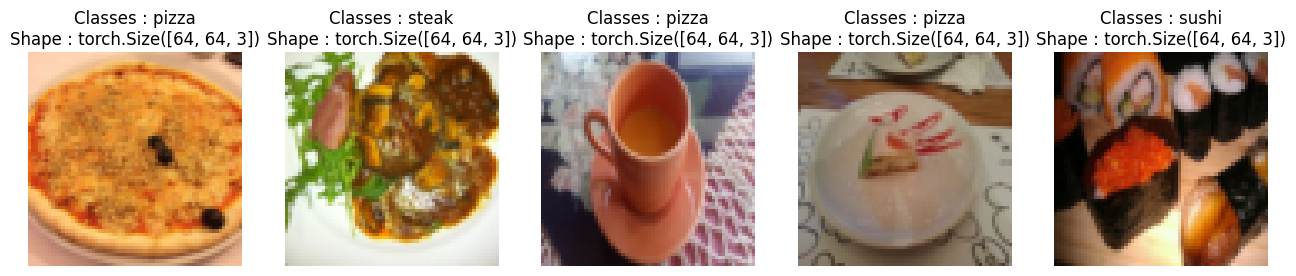

In [43]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset = train_data,
                      n = 5,
                      classes=class_names,
                      seed = None)

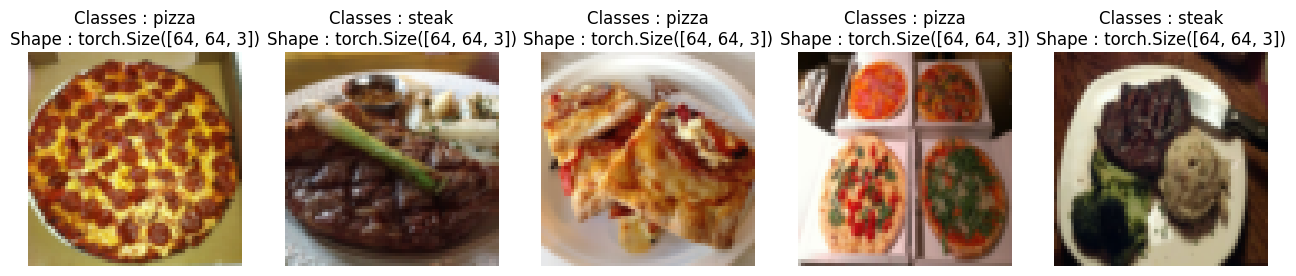

In [44]:
# Display randon images fro the ImageFolderCustom created Dataset
display_random_images(dataset = train_data_custom,
                      n = 5,
                      classes=class_names,
                      seed = None)

### 5.4 Trun custom loaded images into `DataLoader`

In [45]:
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom, 
                                batch_size=BATCH_SIZE, 
                                num_workers=NUM_WORKERS,
                                shuffle=True)
                                
test_dataloader_custom = DataLoader(dataset = test_data_custom, 
                                batch_size=BATCH_SIZE, 
                                num_workers=NUM_WORKERS,
                                shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x132ba7580>,
 <torch.utils.data.dataloader.DataLoader at 0x132b27e80>)

In [46]:
# Get image and label from customer dataloader
img_custom, label_custom = next(iter(train_dataloader))

# Print out the shape of the image and label
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data Augementation is the process of artificially adding diversity to your training data.
In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels.

Blog post : https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

Let's look at the trivailaugment - https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [47]:
from torchvision.transforms.v2 import Compose,Resize,TrivialAugmentWide,ToImage,ToDtype

train_transform = Compose([
    Resize((224,224)),
    TrivialAugmentWide(num_magnitude_bins=31),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

test_transform = Compose([
    Resize((224,224)),
    ToImage(),
    ToDtype(torch.float32, scale=False)
])

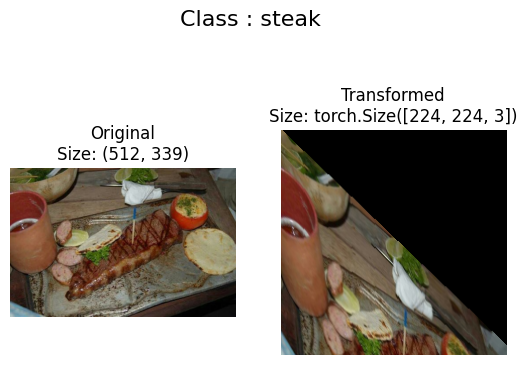

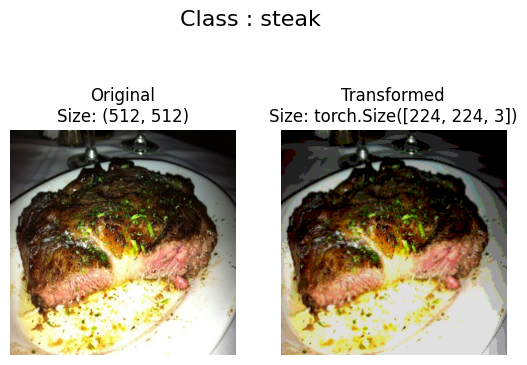

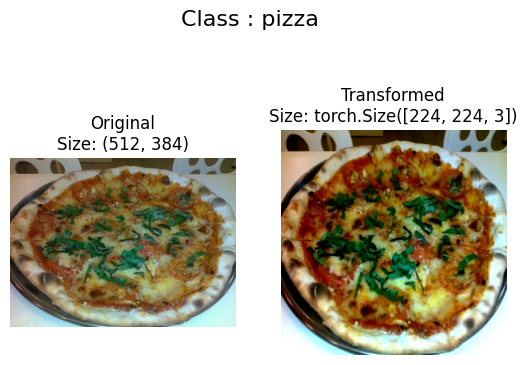

In [49]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random transform image
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        random_seed=None)


## 7. Model 0 : Tiny VGG without data augmentation

### 7.1 Creating transforms and load data for Model 0

In [50]:
# Create Sample Transform
simple_transform = Compose([
    Resize((64, 64)),
    ToImage(),
    ToDtype(torch.float, scale=True),
])

In [51]:
# 1. Load and Transform data
from torchvision import datasets

train_data_sample = datasets.ImageFolder(root=train_dir,transform = simple_transform)
test_data_sample = datasets.ImageFolder(root=test_dir,transform = simple_transform)

# 2. Turn dataset into DataLoader
import os 
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_sample = DataLoader(dataset=train_data_sample,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                shuffle=True)
test_dataloader_sample = DataLoader(dataset=test_data_sample,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                shuffle=False)

### 7.2 Create TinyVGG model class

In [52]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1,
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 13 * 13,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [53]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3  Try a forward pass on a single image (to test the model)
A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the DataLoader.
2. Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target device).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax().

In [54]:
# Get a single batch
image_batch, label_batch = next(iter(train_dataloader_sample))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [55]:
# Try forward pass
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5213e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6610e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9127e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7905e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7978e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7457e-03,  8.4965e-03],
        [ 1.9974e-02, -3.5018e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6379e-03,  8.5490e-03],
        [ 2.0768e-02

### 7.4 Use torchinfo to get an idea of the shapes going through our model

In [56]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train & test loop functions

1. train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [63]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [64]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a train() function to combine train_step() and test_step()

1. Take in a model, a DataLoader for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for train_loss, train_acc, test_loss and test_acc values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled results dictionary.

In [67]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0

In [69]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes))

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_sample,
                        test_dataloader=test_dataloader_sample,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0868 | train_acc: 0.4883 | test_loss: 1.0807 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0843 | train_acc: 0.4023 | test_loss: 1.0608 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4102 | test_loss: 1.0656 | test_acc: 0.5644
Total training time: 315.826 seconds


In [70]:
model_0_results

{'train_loss': [1.106319099664688,
  1.0998042672872543,
  1.0868488252162933,
  1.0842810422182083,
  1.0662355571985245],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41015625],
 'test_loss': [1.0983206431070964,
  1.0696916977564495,
  1.0807169675827026,
  1.060802936553955,
  1.0655698776245117],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curve of Model 0

A **loss curve** is a way of tracking your model's progress overtime.

A good guide for different loss curves can be seen here : http://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [72]:
# Get the model 0 result key
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [73]:
def plot_loss_curve(results : Dict[str, list[float]]):
    """ Plot training curve of a results dictionary."""
    # Get the loss values of the results dictionary(training and testing) 
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    # Get the accuracy values of the results dictionary(training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train accuracy")
    plt.plot(epochs, test_accuracy, label="Test accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

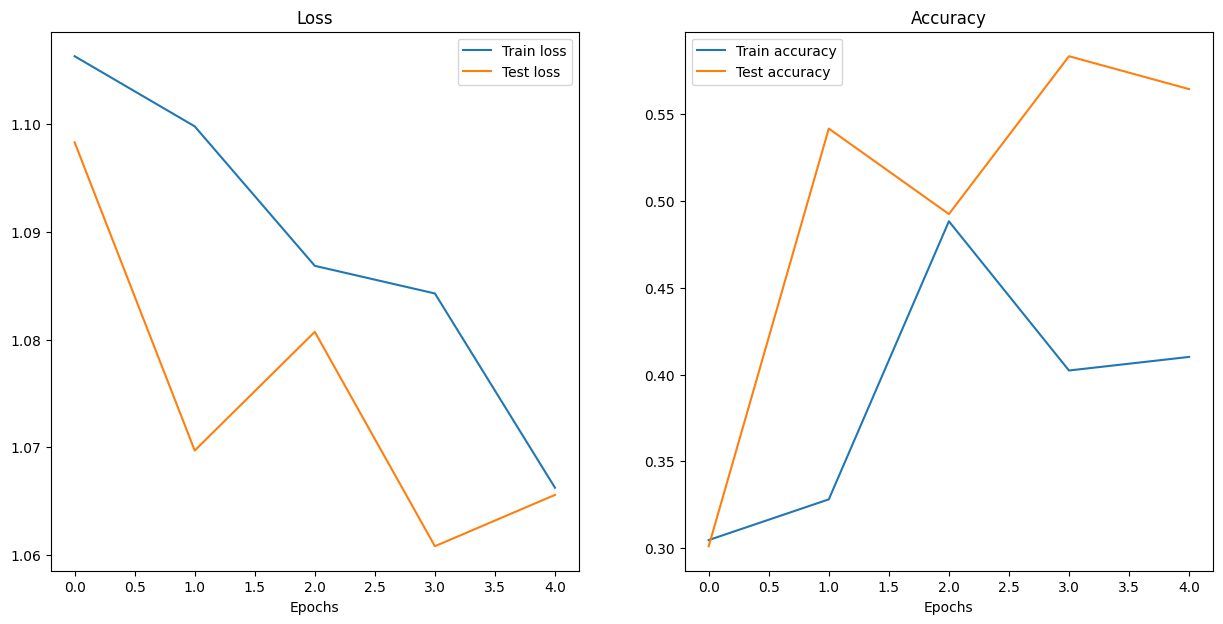

In [76]:
plot_loss_curve(results=model_0_results)

## 8. What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

## 9. Model 1. TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before the same data augmentation pipeline.

### 9.1 Create transfrom with data augmentation

In [77]:
from torchvision.transforms.v2 import Compose, ToImage, ToDtype,Resize,TrivialAugmentWide
train_transform_trivial = Compose([
    Resize((64, 64)),
    TrivialAugmentWide(num_magnitude_bins=31),
    ToImage(),
    ToDtype(torch.float32),
])

test_transform_simple = Compose([
    Resize((64, 64)),
    ToImage(),
    ToDtype(torch.float32),
])

### 9.2 Create train and test `Dataset` and `DataLoader` with data augmentation

In [78]:
# Turn image folders into datasets
from torchvision import datasets   
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)                                          

In [79]:
# Turn out datasets into DataLoader
import os
import torch 
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture as `model_0` expect this time we've augmented the training data.

In [80]:
# Create model 1
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data_augmented.classes))

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we got a model and dataloaders, let create a loss function and optimizer and call upon our `train()` function to train and evaluate our model.

In [81]:
# Set the random seed
torch.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_0, 
                              train_dataloader=train_dataloader_augmented, 
                              test_dataloader=test_dataloader_simple, 
                              loss_fn=loss_fn, 
                              optimizer=optimizer, 
                              epochs=NUM_EPOCHS)

# End timer and print results
end_time = timer()
print(f"Total training time for model 1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2931 | train_acc: 0.5195 | test_loss: 1.2247 | test_acc: 0.3021
Epoch: 2 | train_loss: 1.0783 | train_acc: 0.4922 | test_loss: 1.0268 | test_acc: 0.3314
Epoch: 3 | train_loss: 1.0525 | train_acc: 0.4375 | test_loss: 1.1087 | test_acc: 0.2708
Epoch: 4 | train_loss: 1.0578 | train_acc: 0.3516 | test_loss: 1.1297 | test_acc: 0.2917
Epoch: 5 | train_loss: 0.9915 | train_acc: 0.5586 | test_loss: 1.1571 | test_acc: 0.3646
Total training time for model 1: 318.523 seconds


In [82]:
model_1_results

{'train_loss': [2.293102316558361,
  1.078319825232029,
  1.052515186369419,
  1.0578476339578629,
  0.9914836660027504],
 'train_acc': [0.51953125, 0.4921875, 0.4375, 0.3515625, 0.55859375],
 'test_loss': [1.2247072855631511,
  1.0268251697222393,
  1.1087371110916138,
  1.129713813463847,
  1.1570929686228435],
 'test_acc': [0.3020833333333333,
  0.331439393939394,
  0.2708333333333333,
  0.2916666666666667,
  0.3645833333333333]}

### 9.3 Plot the loss curves of model 1

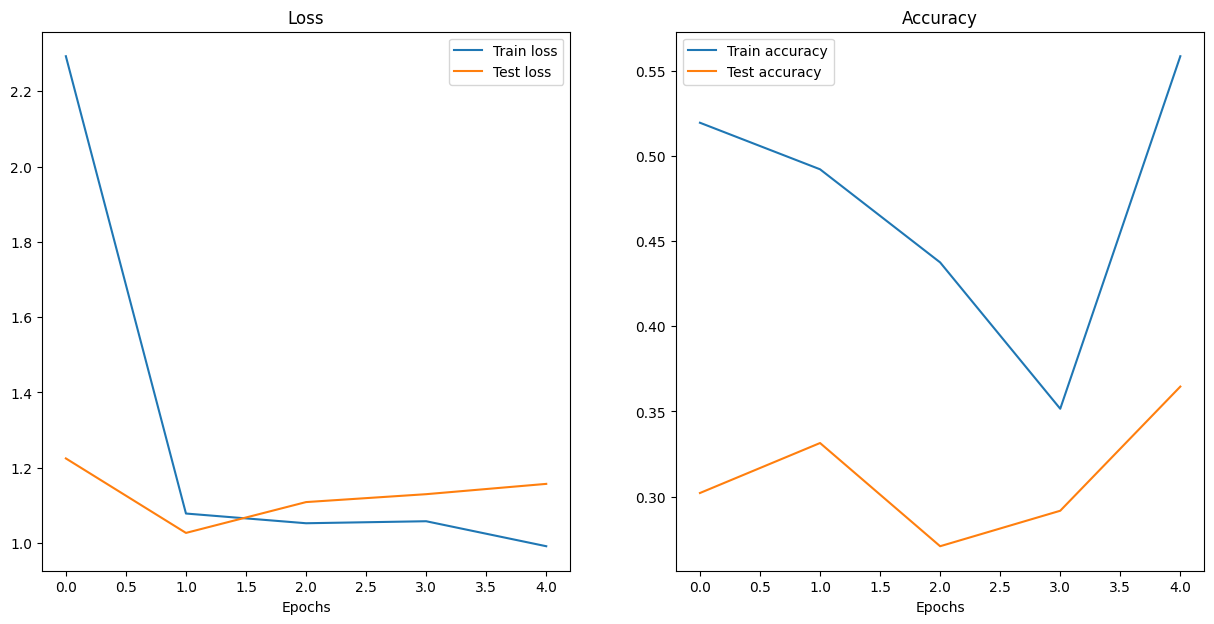

In [83]:
plot_loss_curve(results = model_1_results)

## 10. Compare model results
After evaluation our model experiments on their own, its important to compare them to each other.
There's a few different ways to do this:
1. Hard coding 
2. PyTorch + TensorBoard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases (W&B) - https://wandb.ai/site/experiment-tracking
4. MLflow - https://mlflow.org/

In [84]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099804,0.328125,1.069692,0.541667
2,1.086849,0.488281,1.080717,0.492424
3,1.084281,0.402344,1.060803,0.583333
4,1.066236,0.410156,1.065570,0.564394


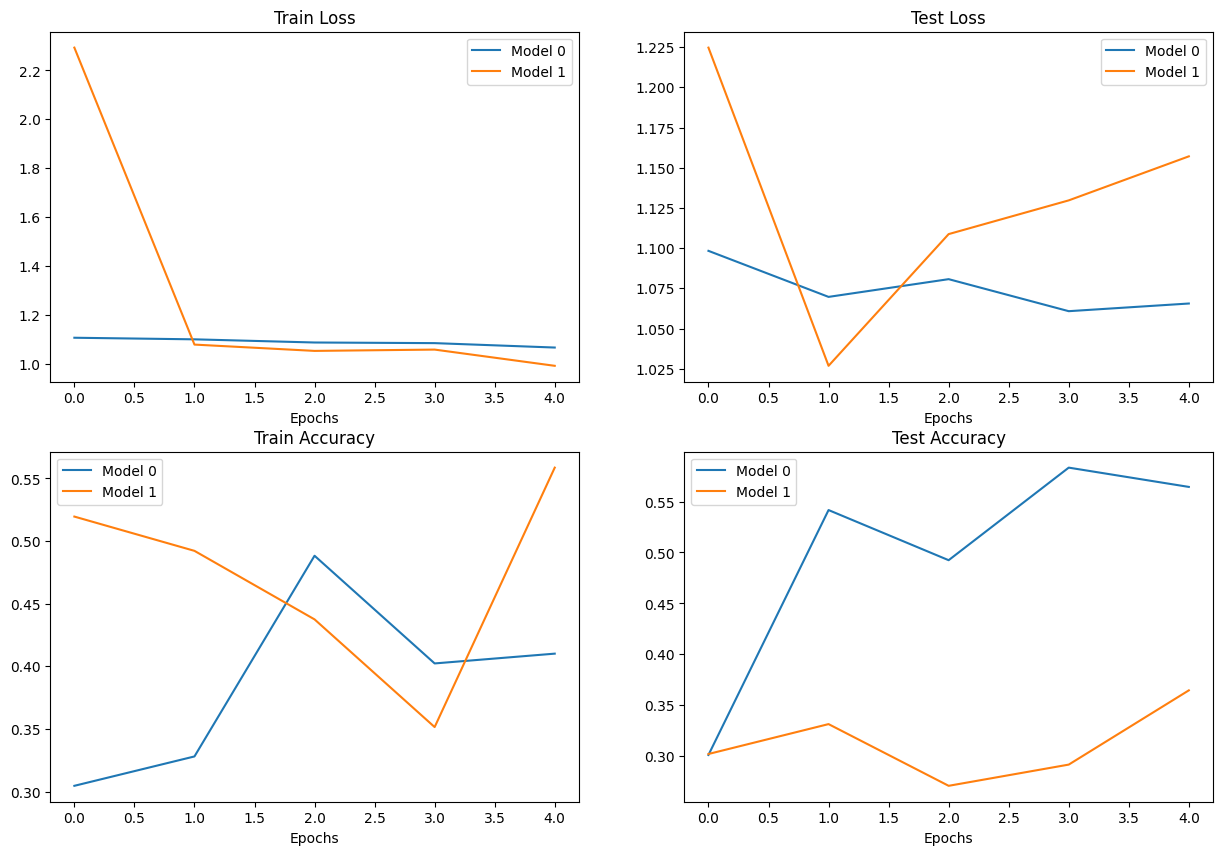

In [85]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image

In [88]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.exists():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use raw iamge
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")

data/04-pizza-dad.jpeg already exists, skipping download...


### 11.1 Loading in custom image with PyTorch
We have to make sure our custom image is in the same format as the images our model was trained on.

* In tensor form with datatype (float32)
* of shape 64x64
* on the right device

We can read an image into PyTorch using - https://docs.pytorch.org/vision/main/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [93]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [94]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom image Tensor: {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image Tensor: tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype

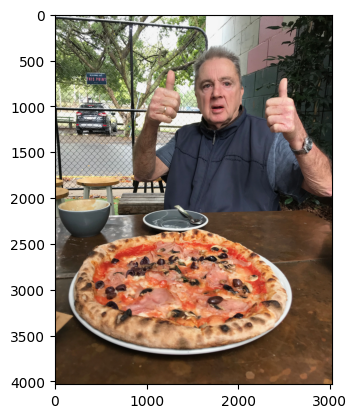

In [95]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 11.2 Predicting on custom images with a trained PyTorch model

In [96]:
# Try to make a predictions on an image in unit8 fromat
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8)

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [102]:
# Load in the custom image and conver to torch.float 

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float) / 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [103]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [104]:
# Create transform pipeline to resize image
custom_image_transform = Compose([
    Resize(size=(64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape} -> New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024]) -> New shape: torch.Size([3, 64, 64])


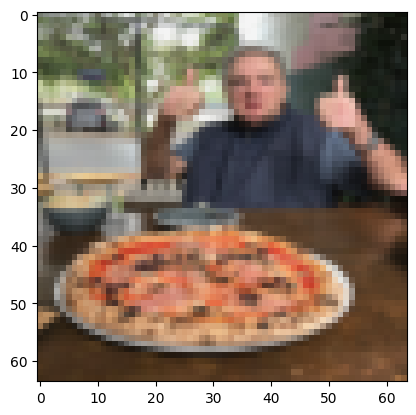

In [105]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# This will error because no batch size
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [108]:
custom_image_transformed.shape,  custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [109]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0))
custom_image_pred

tensor([[0.0231, 0.0006, 0.0066]])

Note, to make a prediction on a custom image we had to:
1. Load the image and turn it to Tensor
2. Make sure the image was the same data type as the model
3. Make sure the image was the same shape as the model with the batch size
4. Make sure the image was on the same device as the model


In [112]:
# Convert logits -> predictions probabilities (using torch.softmax)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3377, 0.3302, 0.3321]])

In [115]:
# Convert predictions probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([0])

In [116]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image together : building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [117]:
def pred_and_plot_image(model : nn.Module,
                        image_path : str,
                        class_names : list[str] = None,
                        transform = None,
                       ):
    """ Make a prediction on a target image with a trained model and plots the image with the prediction. """

    # Load the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float)

    # Divided by the image pixel valus by 255 to get them between [0,1]
    target_image = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # Turn on inference mode and make prediction
    model.eval()
    with torch.inference_mode():
        # Add a extra dimension in the correct axis (this is the batch dimension)
        target_image = target_image.unsqueeze(dim=0)

        # Make prediction
        target_image_pred = model(target_image)
    
    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image along side the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
       title = f"Prediction: {class_names[target_image_pred_label]} | Probability: {target_image_pred_probs.max():.2f}"
    else:
        title = f"Prediction: {target_image_pred_label} | Probability: {target_image_pred_probs.max():.2f}"
    plt.title(title)
    plt.axis(False)


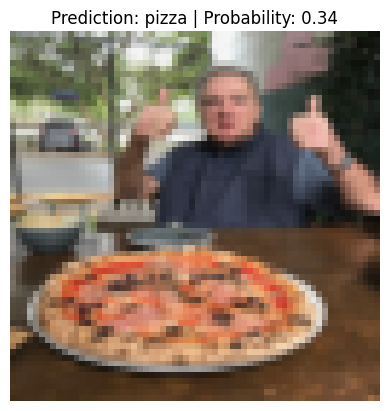

In [ ]:
# Pred on custom image
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform)

In [122]:
pizza_image_path = data_path / "pizza.jpeg"
pizza_image_transform = Compose([
    Resize(size=(64, 64)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

pizza_image_transform

Compose(
      Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
)

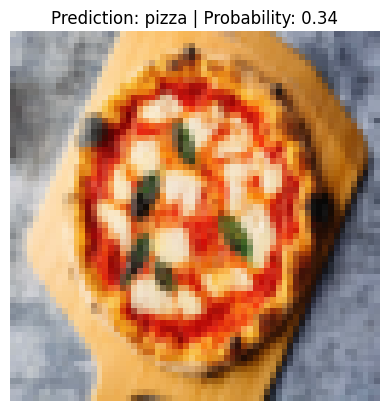

In [123]:
pred_and_plot_image(model = model_1,
                image_path = pizza_image_path,
                transform = pizza_image_transform,
                class_names = class_names
)

In [126]:
sushi_image_path = data_path / "sushi.jpeg"
sushi_image_transform = Compose([
    Resize(size=(64, 64)),
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

sushi_image_transform

Compose(
      Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
)